In [281]:
import numpy as np
import seaborn as sns
from scipy.integrate import solve_ivp
from SALib.sample import saltelli, sobol, fast_sampler
from SALib.analyze import sobol, fast
from scipy.constants import N_A
from scipy.optimize import fsolve
import math
import matplotlib.pyplot as plt
import SALib

In [282]:
Target_cell_number = 2e5
well_size = 150e-6
sigma = well_size*N_A/Target_cell_number
A0s = np.geomspace(1e-13, 5e-5, 80)
t_end = 60*60*1000000
t = np.geomspace(1e-10, t_end, 50)
t_span = [1e-10, t_end]
z0 = [0, 0]
tumour_cell_radius = 8e-6
tumour_cell_surface_area = 4*math.pi*((tumour_cell_radius)**2)

In [283]:
1e4/sigma

2.214052089565129e-11

In [284]:
def A1_steady_state(x, Ainit, k1, koff, k2, rtot):
    k1 = k1/sigma
    Atot = sigma*Ainit
    express = 2*k1*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x))))*(Atot - x - (k2*x*(rtot-x)/(2*(koff + k2*x)))) -koff*x - k2*x*(rtot - x - 2*(k2*x*(rtot-x)/(2*(koff + k2*x)))) +2*koff*(k2*x*(rtot-x)/(2*(koff + k2*x)))

    return express

def A2_steady_state(x, k2, koff, rtot):
    express = k2*x*(rtot-x)/(2*(koff + k2*x))

    return express

def EC50_finder(array, A0s):
    half_max = 0.5*np.max(array) 
    half_max_array = half_max*np.ones_like(array)
    indicies = np.argwhere(np.diff(np.sign(half_max_array-array)))
    return A0s[indicies[0]]

def mono_valent_steady_state(Ainit, k1, koff, rtot):
    k1 = k1/sigma
    Atot = sigma*Ainit
    a = 1
    b = -((koff/k1) + rtot + Atot)
    c = rtot*Atot

    st = (-b - np.sqrt(b**2 - 4*a*c))/(2*a)

    return st

def monovalent_binding(t, z, Ainit, rtot, kon, koff):
     k = kon/sigma
     Atot = well_size*N_A*Ainit/Target_cell_number
     A0 = Atot - z
     Ag = rtot - z

     dA1 = k*Ag*A0 - koff*z

     return dA1

In [285]:
problem = {
    'num_vars': 4,
    'names': ['rtot', 'kon', 'D', 'koff'],
    'bounds': [[1e4, 1e6],
               [1e4, 1e6],
               [1e-15, 1e-13],
               [1e-6, 1e-4]]
}

vals = SALib.sample.sobol.sample(problem, 4096)
Y = np.zeros(len(vals))

In [286]:
16384/4

4096.0

In [287]:

for i, params in enumerate(vals):
    print(i)
    rtot = params[0]
    kon = params[1]
    D = params[2]
    koff = params[3]
    k2 = 4*D/tumour_cell_surface_area

    
    Ainit_array = np.zeros_like(A0s)

    for j, A0 in enumerate(A0s):

        z = solve_ivp(monovalent_binding, t_span, [0], method='Radau', t_eval=t, args=(A0, rtot, kon, koff))

        """
        A1_st = fsolve(A1_steady_state, [0], args=(A0, kon, koff, k2, rtot))
        A2_st = A2_steady_state(A1_st, k2, koff, rtot)
        if (A1_st < 0) or (A2_st < 0) :
            print('negative')
        
        if ((A1_st + 2*A2_st) > rtot):
            print('blown up')

        Ab = A1_st + 2*A2_st
        """
        Ab = z.y[0]
        Ainit_array[j] = Ab[-1]
    
    #biv_ec50 = EC50_finder(Ainit_array, A0s)

    #mono_ec50 = EC50_finder(mono_valent_steady_state(A0s, kon, koff, rtot), A0s)
    mono_ec50 = EC50_finder(Ainit_array, A0s)
    Y[i] = mono_ec50
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


KeyboardInterrupt: 

In [ ]:
Si = sobol.analyze(problem, Y, print_to_console=True)

            ST   ST_conf
rtot  0.265386  0.038020
kon   0.691068  0.079185
D     0.000000  0.000000
koff  0.209458  0.046922
            S1   S1_conf
rtot  0.253607  0.040985
kon   0.506256  0.100857
D     0.000000  0.000000
koff  0.045777  0.017286
                    S2       S2_conf
(rtot, kon)  -0.005052  3.727059e-02
(rtot, D)    -0.000224  2.819114e-02
(rtot, koff)  0.004402  2.782729e-02
(kon, D)      0.018789  1.797602e-01
(kon, koff)   0.143280  2.074550e-01
(D, koff)     0.000000  1.977874e-17


In [ ]:
total, first, second = Si.to_df()
sns.set_context('talk')

In [ ]:
array = list(total['ST'].values)
array.append(0)

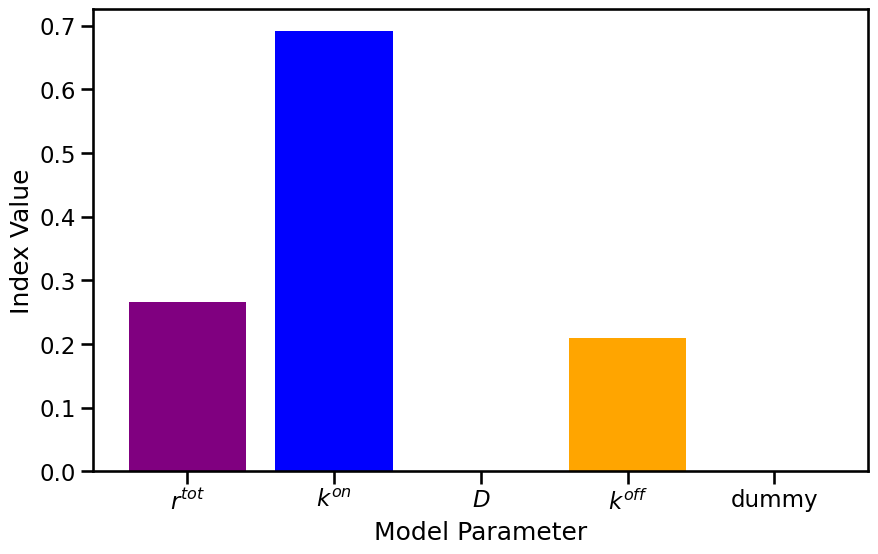

In [ ]:
fig, ax = plt.subplots(1,1, figsize=(10,6))
ax.bar(x =[r'$r^{tot}$', r'$k^{on}$', r'$D$', r'$k^{off}$', 'dummy'],  height=array, color=['purple', 'blue', 'skyblue', 'orange', 'black'])
ax.set_ylabel('Index Value')
ax.set_xlabel('Model Parameter')
fig.savefig('/Users/lukeheirene/ADCC-Project/Figures/monovalent_ec50_receptor_occupancy_first_order_sensiv_analysis.png')